In [1]:
from datasets import load_dataset,Dataset
import sys
import os
from pathlib import Path
sys.path.append('/home/x_lv/texture/RADAM/RADAM')
from feature_extraction import extract_features
from datasets_ import Texture_D
import pickle
from PIL import Image
import  json
def getListOfTextures(dirName):
    # create a list of all files in a root dir
    path=Path(dirName)
    
    for file in path.rglob("*.json") :
        print(file)
        if file.is_file()  : #and int(file.stem) !=5456 :# and file.parent.name not in ["shape","perlin_noise","gradient_linear_1","gradient_linear_2","gradient_linear_3","crystal_2","clouds_2","bnw_spots_3","brick_generator","stripes"]:
            print(file)
            text=[] 
            conditioning_image=[]
            with open(file,"r") as f:
                params=json.load(f)
                
            if "input"  in  list(params.values())[0]:
                for index,i in enumerate(list(params.values())[0]["input"]):
                    if i != None:
                        cond_path=file.parents[2]/Path(i).as_posix().replace("\\","/")
                        conditioning_image.append(Image.open(cond_path) )
                        text.append(list(params.keys())[0]+f":input{index}")
            else:
                raise ValueError("node has no input")
            image=Image.open(file.with_suffix(".png")) 
            
            for index,con_img in enumerate(conditioning_image):
                yield {"conditional_image":image,"label":text[index],"additional_image":image,"label_image":con_img} 

        else:
            continue
    '''if dirName not in ["gradient"]:
        listOfFile = os.listdir(dirName)
        
        for entry in listOfFile:


                fullPath = os.path.join(dirName, entry)
                
                if os.path.isdir(fullPath):
                     getListOfTextures(fullPath)
                else:
                    if os.path.splitext(entry)[1] ==".json":
                        pathname = os.path.join(dirName,os.path.splitext(entry)[0])
                        with open("/home/x_lv/texture/RADAM/RADAM/lable_pair.pkl","rb") as f:
                            lable_pair=pickle.load(f)
                        with open( pathname+".json","r") as f :
                            label=lable_pair.get(list(json.load(f).keys())[0])
                        image=Image(pathname+".png").convert("RGB")
                        yield {"image":image,"label":label}'''

x=Dataset.from_generator(lambda:getListOfTextures("/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale"),cache_dir="~/.cache/huggingface/datasets/safe_transform_grayscale")
 
 
  

Generating train split: 0 examples [00:00, ? examples/s]

/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/686.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/686.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2916.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2916.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/1809.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/1809.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2495.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2495.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/1553.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/1553.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2637.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale/2637.json
/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscal

['distance:input0', 'distance:input1']
9412
9.5


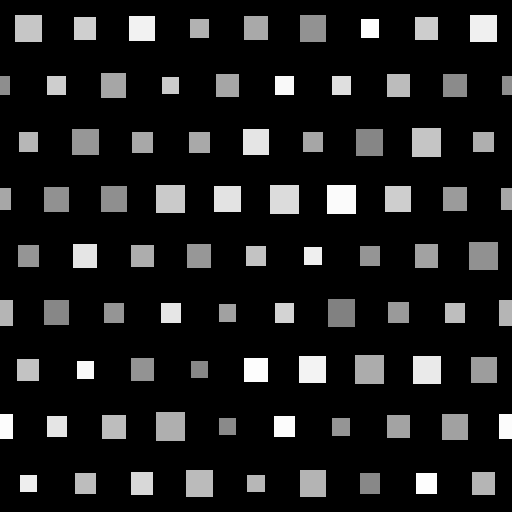

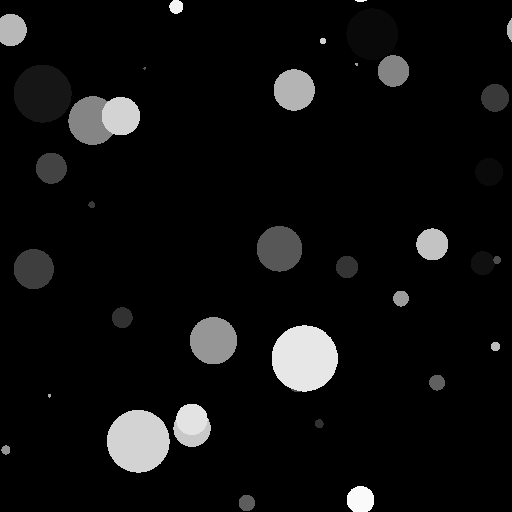

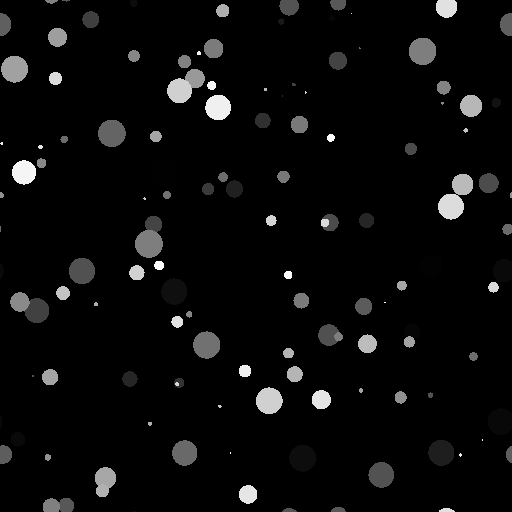

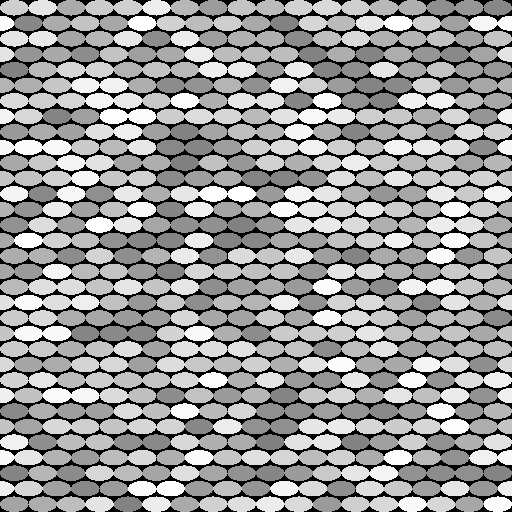

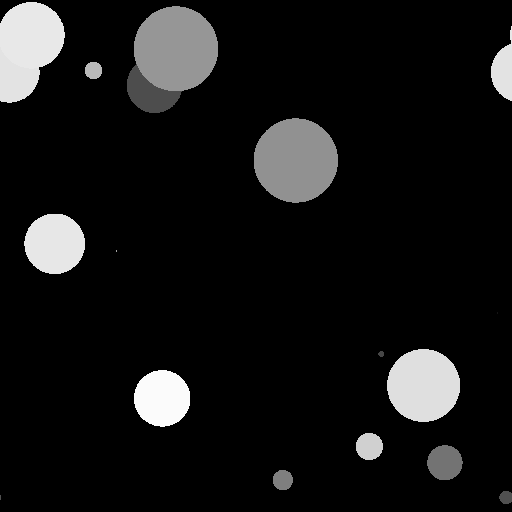

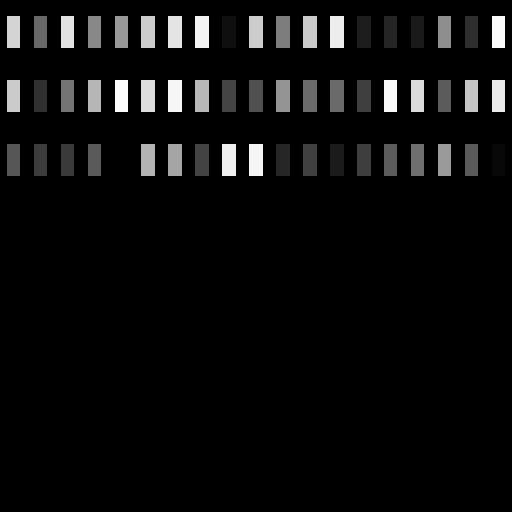

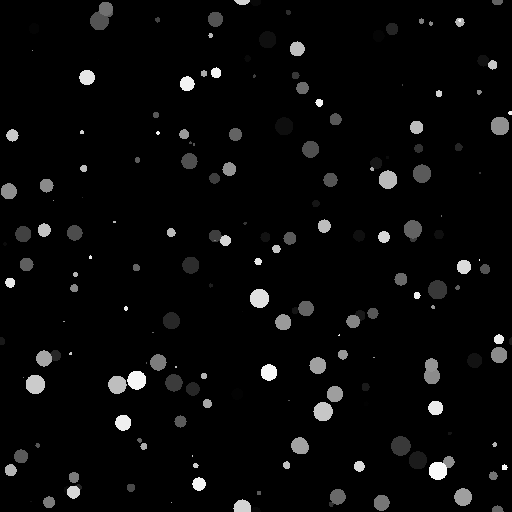

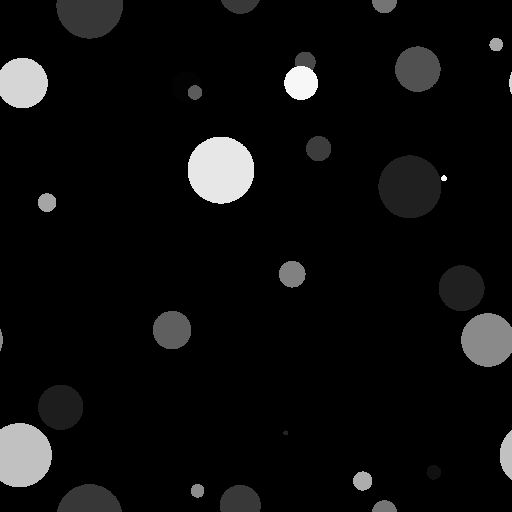

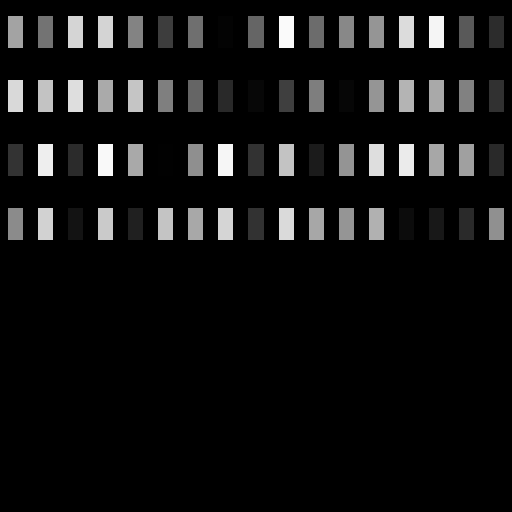

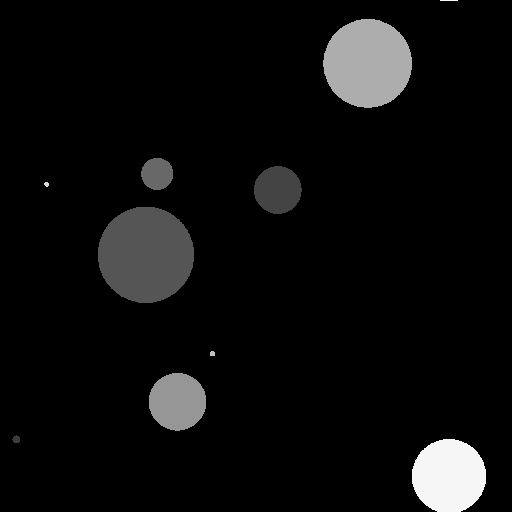

In [5]:
from  datasets import load_dataset,DatasetDict
import numpy as np 
data_path="/home/x_lv/.cache/huggingface/datasets/distance_2/generator/default-3afc4de49bce0eed"   
dataset=load_dataset(data_path,split="train")
    
dataset_type=list(set(dataset["label"]))
print(dataset_type)
print(len(dataset))
dataset_index=0
if len(dataset_type) >1:
    dataset=dataset.filter(lambda x : "distance:input0" in x["label"] )   #x["label"] ==  "blend_mask_two_noise_blending_mode_copy:input2")
node_type=dataset[0]["label"]
 
dataset=dataset.train_test_split(test_size=0.004,shuffle=True,generator=np.random.default_rng(seed=1))
print(len(dataset["test"])/2)
for i,img in enumerate(dataset["test"]):
    
    if i %2 ==0:
        
        display(img["label_image"])
    

100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


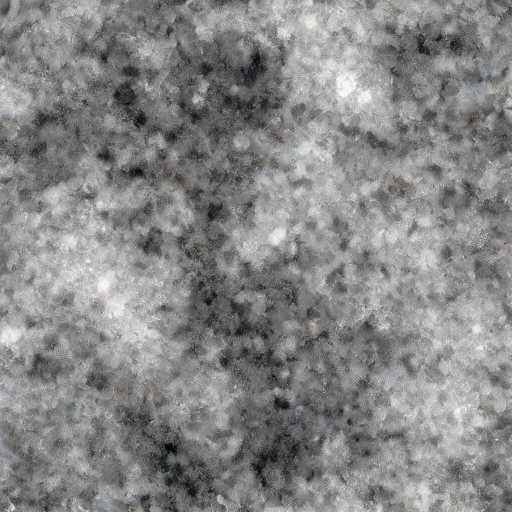

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ["http_proxy"] = "http://10.10.115.13:7897"
os.environ["https_proxy"] = "http://10.10.115.13:7897"
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from model import img_embedding
import torch 
from custom_pipeline import StableDiffusionXLCustomPipeline
from PIL import Image
import numpy as np
id="stabilityai/stable-diffusion-xl-base-1.0"  #"stabilityai/stable-diffusion-xl-base-1.0"  
device="cuda"

unet=UNet2DConditionModel.from_pretrained(id,subfolder="unet",torch_dtype=torch.float16).to(device)
unet.requires_grad_(False)
vae=AutoencoderKL.from_pretrained(id,subfolder='vae',torch_dtype=torch.float16).to(device)
vae.requires_grad_(False)
scheduler=DDIMScheduler.from_pretrained(id,subfolder="scheduler")
scheduler.set_timesteps(50)

image_encoder = CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter", subfolder="models/image_encoder",torch_dtype=torch.float16).to(device)
#text_encoder.requires_grad_(False)
image_encoder.requires_grad_(False)
clip_image_processor=CLIPImageProcessor()

img_emb_model=img_embedding( ).to(device,torch.float16)  #image_proj_model, adapter_modules
z=torch.load("/work/imc_lab/x_lv/ckpt/img_emb_model/bevel:input0/_ssim_avg:0.00_steps:43499.pth")
img_emb_model.load_state_dict(z) 

img=Image.open("/work/imc_lab/x_lv/output/final_dataset/pbr/14.png").convert("RGB")

pipe=StableDiffusionXLCustomPipeline(vae,unet,scheduler,image_encoder,clip_image_processor,img_emb_model)
output=pipe(img,device,dtype=torch.float16)[0]

'''image_np = np.array(output)
for i in range(image_np.shape[0]):
    for j in range(image_np.shape[1]):
        image_np[i,j,:]= [max(image_np[i,j,:]),max(image_np[i,j,:]),max(image_np[i,j,:])] if  (max(image_np[i,j,:])-min(image_np[i,j,:])) <5 else image_np[i,j,:]
    # 获取 R, G, B 通道
r, g, b = image_np[:,:,0], image_np[:,:,1], image_np[:,:,2]

mask = (r <= 10) & (g <= 10) & (b <= 10)

image_np[mask] = [0, 0, 0]

mask_ = (r >= 250) & (g >= 250) & (b >= 250)

image_np[mask_] = [255,255,255]

# 将 NumPy 数组转换回图片
new_image = Image.fromarray(image_np.astype("uint8"))
'''
 


display(output)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/19 [00:00<?, ?it/s]

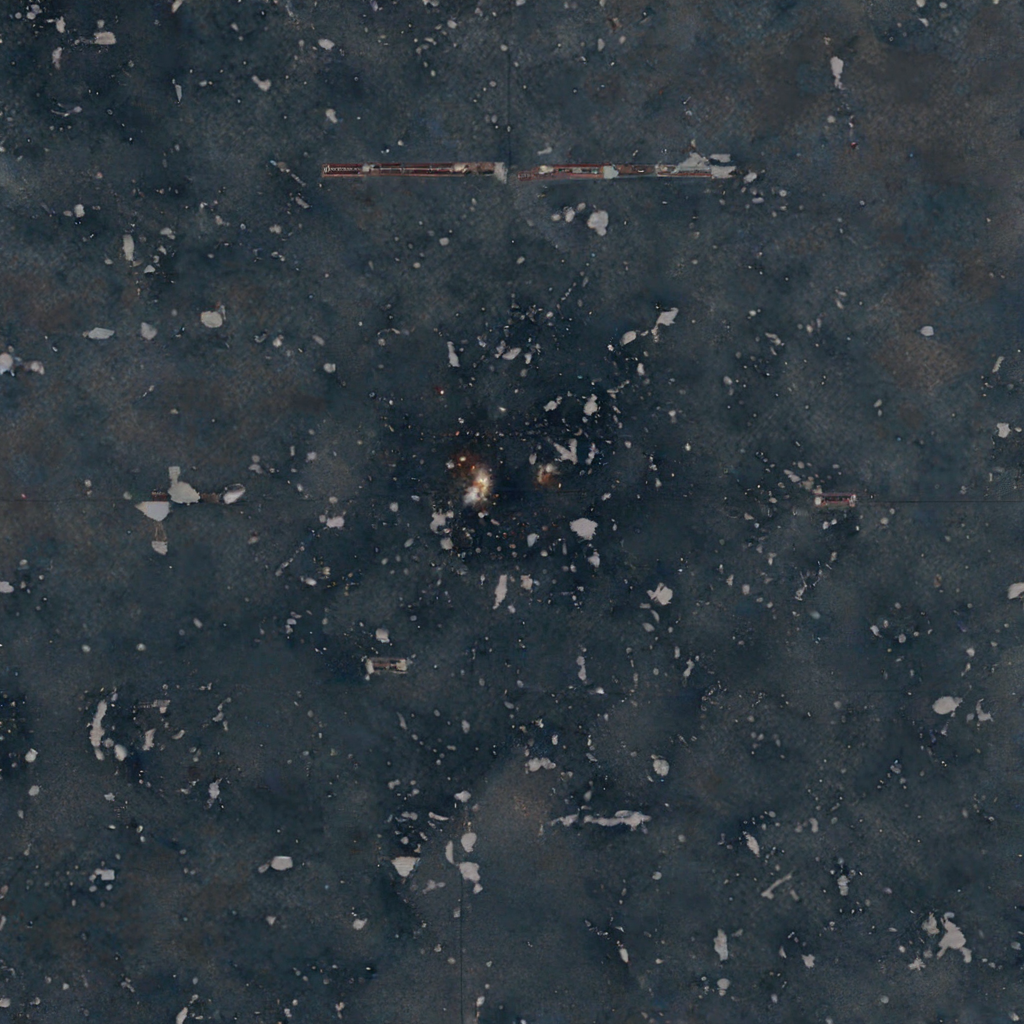

In [38]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
os.environ["http_proxy"] = "http://10.10.115.11:7890"
os.environ["https_proxy"] = "http://10.10.115.11:7890"
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLInpaintPipeline,AutoPipelineForInpainting,StableDiffusionInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor,CLIPVisionModel,CLIPImageProcessor
from PIL import Image
import torch 
from safetensors.torch import load_file
 
embed = load_file("/home/x_lv/texture/diffusers/examples/textual_inversion/textual_inversion_cat/learned_embeds-steps-800.safetensors")
embeds_2=load_file("/home/x_lv/texture/diffusers/examples/textual_inversion/textual_inversion_cat/learned_embeds_2-steps-800.safetensors")
 
pipeline = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16
).to("cuda")

pipeline.load_textual_inversion(embeds_2, token="lxy", text_encoder=pipeline.text_encoder_2, tokenizer=pipeline.tokenizer_2)
pipeline.load_textual_inversion(embed, token="lxy", text_encoder=pipeline.text_encoder, tokenizer=pipeline.tokenizer)
image_encoder = CLIPVisionModelWithProjection.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
processor = CLIPImageProcessor() 
img=Image.open("/work/imc_lab/x_lv/output/generator_output/dyngradient/21526.png")
init_image=Image.open("/home/x_lv/texture/experiment/output/blend_mask_two_noise_blending_mode_copy.png").convert("RGB")
mask_image=Image.open("/home/x_lv/texture/experiment/output/histogram_scan.png").convert("RGB")

'''img=processor(img)["pixel_values"]
img=torch.as_tensor(img)
image_embeds = image_encoder(img,output_hidden_states=True).image_embeds.unsqueeze(0)
print(image_embeds.shape)'''
negative_prompt_embeds=torch.randn(1,1,1024)
image = pipeline( prompt="lxy",image=init_image, mask_image=mask_image,guidance_scale=7.5,strength=0.999,num_inference_steps=20,target_size=(512,512)) #prompt_embeds=image_embeds,negative_prompt_embeds=negative_prompt_embeds, 
display(image.images[0])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

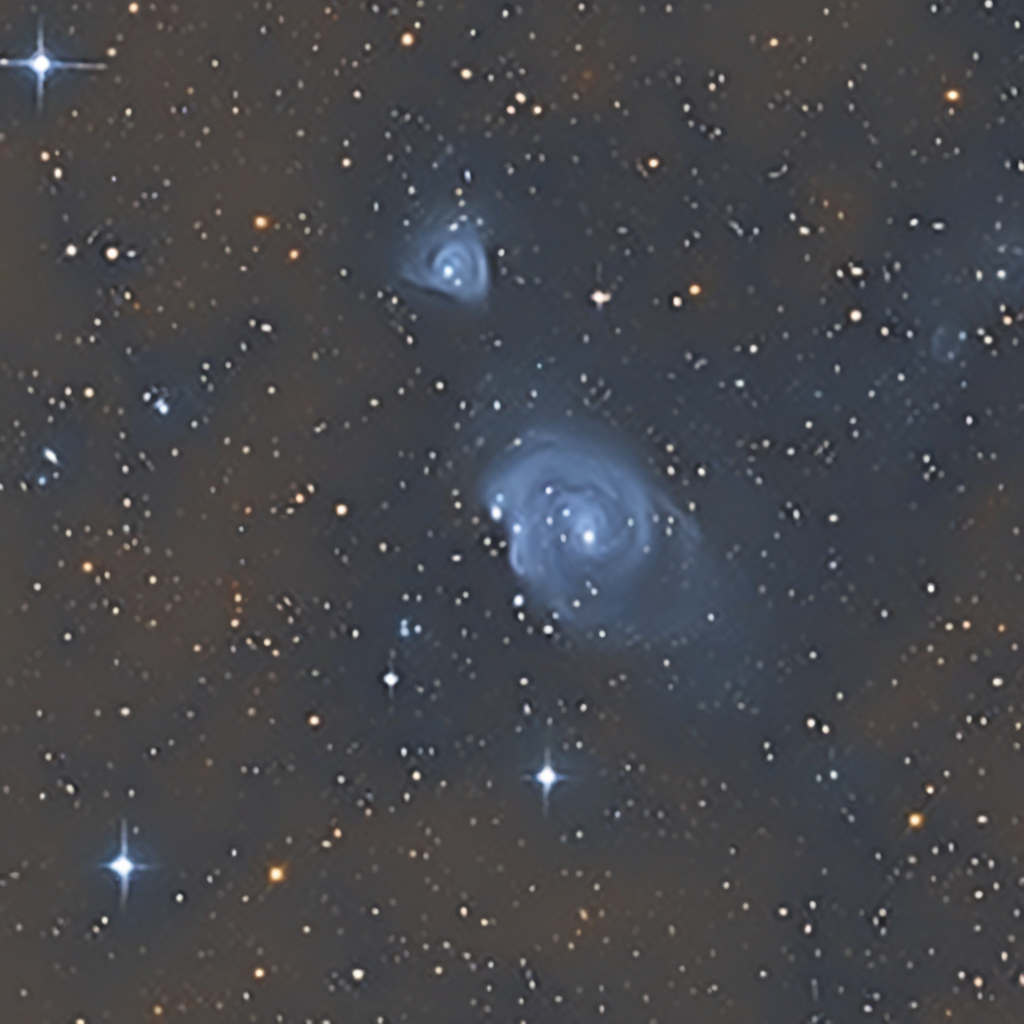

In [33]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ["http_proxy"] = "http://10.10.115.11:7890"
os.environ["https_proxy"] = "http://10.10.115.11:7890"
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLPipeline,StableDiffusionXLInpaintPipeline,AutoPipelineForInpainting,StableDiffusionInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor,CLIPVisionModel,CLIPImageProcessor
from PIL import Image
import torch 
from safetensors.torch import load_file
 
embed = load_file("/home/x_lv/texture/diffusers/examples/textual_inversion/textual_inversion_cat/learned_embeds-steps-1000.safetensors")
#embed_ = load_file("/home/x_lv/texture/experiment/textual_inversion_img_emb/learned_embeds-steps-500.safetensors")
embeds_2=load_file("/home/x_lv/texture/diffusers/examples/textual_inversion/textual_inversion_cat/learned_embeds_2-steps-1000.safetensors")
 
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
).to("cuda")

pipeline.load_textual_inversion(embeds_2, token="lxy", text_encoder=pipeline.text_encoder_2, tokenizer=pipeline.tokenizer_2)
pipeline.load_textual_inversion(embed, token="lxy", text_encoder=pipeline.text_encoder, tokenizer=pipeline.tokenizer)
image = pipeline(
    prompt="lxy",
    num_inference_steps=20,
    guidance_scale=8
).images
display(image[0])

[(0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F890C2EE0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F84EEA9D0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F70339A9C40>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F894881C0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F89272580>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F894A97F0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F89488310>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F894A9B20>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D8B0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D910>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D8E0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D9A0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D9D0>), (0, <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6F8908D6D0>), (0, <PIL.Image.Imag

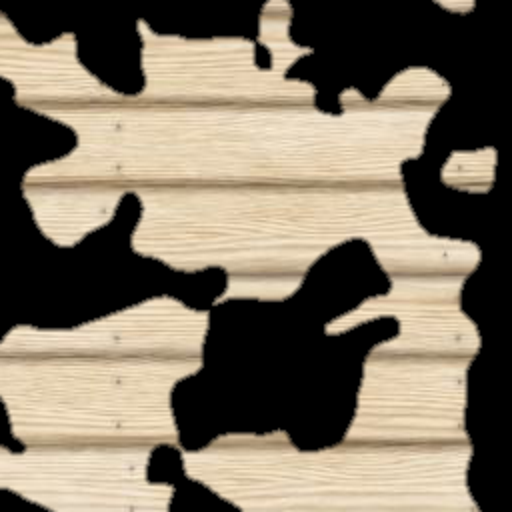

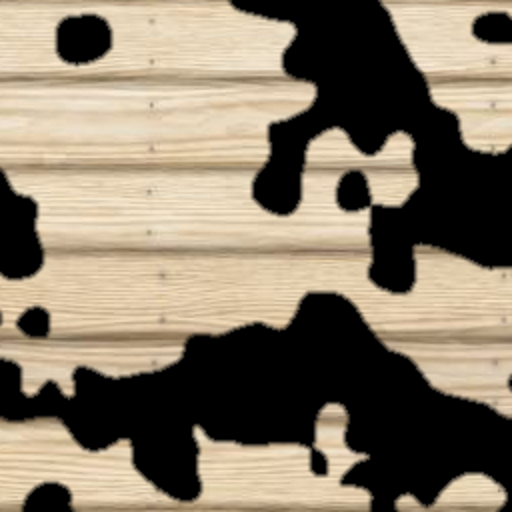

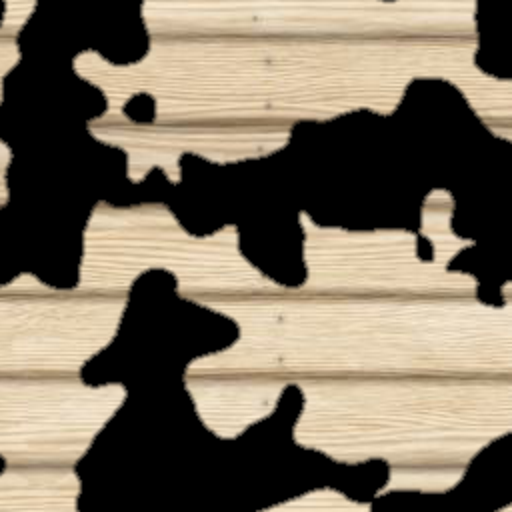

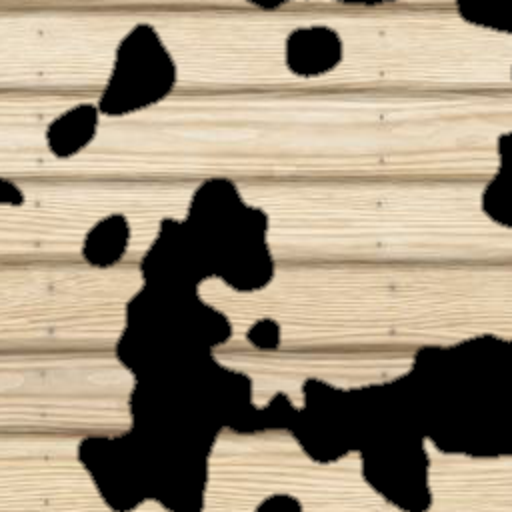

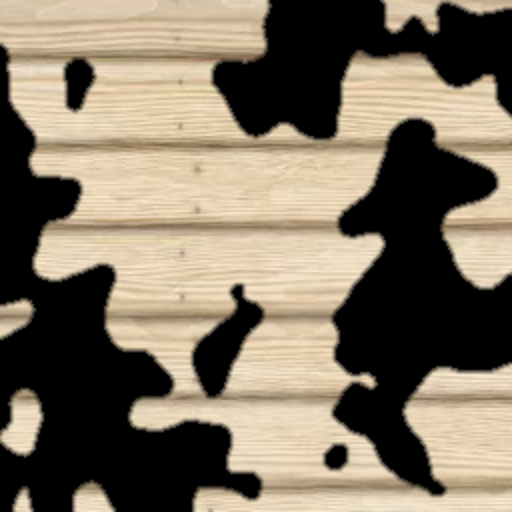

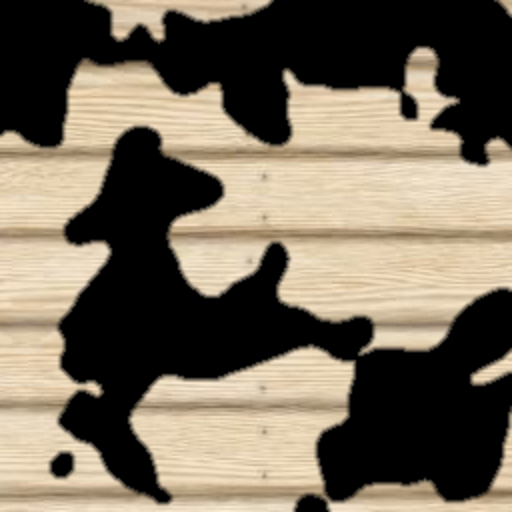

In [14]:
from pathlib import Path
from PIL import Image
import numpy as np 
img=Image.open("/work/imc_lab/x_lv/output/final_dataset/mask_/mask_1.png")

# 获取图片的尺寸
width, height = img.size

# 计算每个子图片的尺寸
sub_width = width // 2
sub_height = height // 2

# 创建4个新的图片对象，用于存储裁剪后的子图片
sub_imgs = [Image.new('L', (sub_width, sub_height)) for _ in range(10)]
'''for i in range(2):
    for j in range(2):
        sub_imgs[i * 2 + j].paste(img, (-j * sub_width,-i * sub_height))'''
sort_list=[]
img_=[]
for i in range(20):
    x1=np.random.randint(0,255)
    
    y1=np.random.randint(0,255)
 
    img_.append(img.crop((x1,y1,x1+256,y1+256)))
    
    #sub_imgs[i].paste(img, (-x1,-y1))
for i in range(20):
    zero_pixels_count=0    
    for y in range(sub_height):
        for x in range(sub_height):
            pixel_value = img_[i].getpixel((y, x))
            if pixel_value == 0:
                zero_pixels_count += 1
    sort_list.append((zero_pixels_count,img_[i]))
 
out_list=sorted(sort_list,key=lambda x:x[0])
print(out_list)
for i in range(6):
    sub_img=out_list[i][1]
    sub_img=sub_img.resize((512,512),resample=Image.Resampling.BILINEAR)
    sub_img.save("/work/imc_lab/x_lv/output/final_dataset/mask/"+str(i)+".png")
    display(sub_img)  # 显示子图片

In [2]:
import sys
import torch
import os
from safetensors.torch import load_file
from PIL import Image
import subprocess
 
commands=["python","../../diffusers/examples/textual_inversion/textual_inversion_sdxl.py",
              "--pretrained_model_name_or_path","stabilityai/stable-diffusion-xl-base-1.0",
              "--train_data_dir","/mask",
              "--learnable_property","object" ,
              "--placeholder_token","lxy" ,
                "--initializer_token","pattern" ,
                "--resolution","512" ,
                "--train_batch_size","2" ,
                "--gradient_accumulation_steps","1" ,
                "--max_train_steps","100" ,
                "--learning_rate","5.0e-04" ,
                "--lr_scheduler","constant" ,
                "--lr_warmup_steps","0" ,
                "--output_dir","textual_inversion_cat" ,
                "--report_to","wandb"
                ]
result=subprocess.run(commands,capture_output=True, text=True)
print(result.stderr)

09/08/2024 21:36:32 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

/home/x_lv/anaconda3/envs/timm_texture/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
{'clip_sample_range', 'rescale_betas_zero_snr', 'thresholding', 'dynamic_thresholding_ratio', 'variance_type'} was not found in config. Values will be initialized to default values.
{'latents_std', 'shift_factor', 'mid_block_add_attention', 'latents_mean', 'use_post_quant_conv', 'use_quant_conv'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'attention_type', 'dropout'} was not found in config. Values will be initialized to default values.
wandb: Current

In [6]:
import os
import timm
import torch   
import sys
import subprocess
commands=['python','-u',"/home/x_lv/texture/diffusers/examples/textual_inversion/textual_inversion_sdxl.py",
              "--pretrained_model_name_or_path","stabilityai/stable-diffusion-xl-base-1.0",
              "--train_data_dir","/home/x_lv/texture/experiment/mask_emb",
              "--learnable_property","object" ,
              "--placeholder_token","lxy" ,
                "--initializer_token","pattern" ,
                "--resolution","512" ,
                "--train_batch_size","1" ,
                "--gradient_accumulation_steps","1" ,
                "--max_train_steps","10" ,
                "--learning_rate","5.0e-04" ,
                "--lr_scheduler","constant" ,
                "--lr_warmup_steps","0" ,
                "--output_dir","textual_inversion_img_emb" ,
                "--report_to","wandb","--checkpointing_steps","1000"
                ]
process = subprocess.Popen(commands,shell=False,bufsize=1 ,text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

while process.poll() is None:
            line = process.stderr.readline()
            process.stderr.flush() # 刷新缓存，防止缓存过多造成卡死
            #line = line.decode("utf8") 
            print(line)
 

x=process.wait()

print(x)


09/11/2024 11:56:18 - INFO - __main__ - Distributed environment: NO

Num processes: 1

Process index: 0

Local process index: 0

Device: cuda



Mixed precision type: no



/home/x_lv/anaconda3/envs/timm_texture/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

  warnings.warn(

{'clip_sample_range', 'thresholding', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr', 'variance_type'} was not found in config. Values will be initialized to default values.

{'mid_block_add_attention', 'latents_std', 'use_post_quant_conv', 'shift_factor', 'use_quant_conv', 'latents_mean'} was not found in config. Values will be initialized to default values.

{'dropout', 'attention_type', 'reverse_transformer_layers_per_block'} was not found in config. Values will be initialized to default values.

w

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00{\x1aC\xad\x00\x01\x00\x00IDATx^t\xbd\xcd\xd6\xe4:\x8f\xac\xf7\x04\xa8\xda\xdd>g\xf9\xba|\x03\x1e\xfa\xfe\'^\x1e\xd9\xabO\xf7\xae$\xc2\x83\x00\x99zk\x7f\xcdz+S\xa2\xf8\x03\x04@\x00\xa4(\xa5\xfe\xaf\xff\xf3\xff\xd8{{\x7f\xfcq\xed\xbf\xff\xe2\xf7_\xfd\xff\xfeO\xfd\x7f\x7f\xfd\xfe\x7f~\xf9\xf7_\xfe\x1f*\x04\xcf*!\x89\xfc\x95\x00ak\xe5:\x92\x00l\xdb$i\xbe\x81\xee\x96TR\x8a\xe9\x1c a\xe7\xb8\xaa\xee\xc5\xd4\xca\xd74(\xd2BN\xfd3\xa5Zj\x95\x84\xe4/Iik\xae\xda\x0e1\xd3\xec\xf7\xfa\x9b\x0bl\xa7L\x8a\xb5\x1b\xb8\x9c\xdd\xcc\xd3\x8el\x0c\x98\xb6m,\xd9\xb8\xdb`If\xa7J\xbb\xed\xff\xfb\xc3_\xbf\xffK\xeeB\x05h\x89O\xe9\xa9\xb2jAK*\xb6\xf4H\x14RIP\xab\x96\x10T\t(\xa9j\xb0\n\xb0*\xd9\xbe \x0e\xad!>\x94\xff\x04\x8a\x03c\x1f\x11\xbc\xf3\xd3L\x8e/\xe7\x92\xf8"\xf7\x95\xf0\x14\x964r\x0cUQ\r\xf8\nq\xe0\xed\xee\xaf\x80 Py@\xa4}`\xf3\x11tJ\x9d\x8fNI)\x19>\x15\xe8\xd3\x94\xe4\x1c\xa7 \xd2\xe7\xb7%\xf1\xc1\xcb\xde\xad\xe0\\

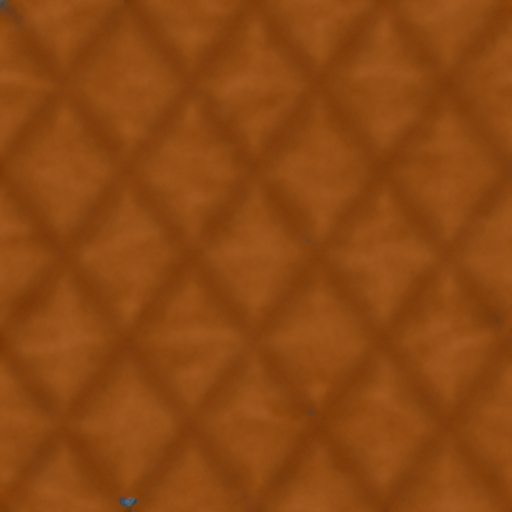

In [2]:
from pathlib import Path
import pickle
import weakref
import queue
from PIL import Image
import numpy as np 
import requests
import io
'''with open("/home/x_lv/texture/experiment/output/blend_mask_two_noise_blending_mode_copy.png", 'rb') as fd:
    init_image = fd.read()'''
init_image=Image.open("/home/x_lv/texture/experiment/output/0_gradient_None_None.png")
init_byte_arr = io.BytesIO()
init_image.save(init_byte_arr, format='png')
init_byte_arr=init_byte_arr.getvalue()

mask_image=Image.open("/home/x_lv/texture/experiment/output/1_mask.png")
init_byte_arr1 = io.BytesIO()
mask_image.save(init_byte_arr1, format='png')
init_byte_arr1=init_byte_arr1.getvalue()
'''with open("/home/x_lv/mask_.png", 'rb') as fd:
    mask_image = fd.read()'''

r = requests.post('https://clipdrop-api.co/cleanup/v1',
  files = {
    'image_file': ('image.jpg', init_byte_arr, 'image/jpeg'),
    'mask_file': ('mask.png', init_byte_arr1, 'image/png'),
    #'mode': ("mode","quality","text/plain")
    },
  data = { "mode": "quality" },
  headers = { 'x-api-key': '3fe906cef09c37bb5e2417f701ed47b258d360a1c9ab1ae1eaeb085641e8c4c0b36718612fd13c136069d403365a55f8'}

)
if (r.ok):
  # r.content contains the bytes of the returned image
  display(r.content)
else:
  r.raise_for_status()
import io
image_stream = io.BytesIO(r.content)

# 使用Image.open()从文件对象中打开图像
image = Image.open(image_stream)
display(image)



In [6]:
import numpy as np 
from PIL import Image
from pathlib import Path
path=Path("/work/imc_lab/x_lv/output/generator_output/tile_generator")
for file in path.rglob("*.png"):
    img = Image.open(file)
    if img.mode == "I" :
        x= np.array(img)
        print(x.max())
        pass

42537
65527
42993
65316
45426
44398
36261
51590
35215
56086
57601
46531
65511
42247
39615
54927
52679
35376
33548
45559
51459
36598
65489
44008
46309
65486
43460
53462
30904
31092
54147
54432
65438
57969
54023
45831
37236
42799
39448
50487
54715
65431
40723
36499
40494
47777
57422
65265
42238
45185
65142
39104
65211
65437
45642
65520
41344
60372
65352
39810
48681
65499
44548
39610
46979
37252
37405
65501
58159
57769
39693
37334
45130
34928
36365
65473
55062
55766
58073
56800
37904
59321
32781
46221
43497
65472
40169
37018
44069
58566
37507
65519
44750
65501
41611
35789
56851
57890
65417
65392
55714
56396
65393
42371
36604
59938
35949
65491
39569
65489
50186
29958
39575
30297
56278
50200
54762
40823
65503
65451
42358
65528
47588
56221
37183
65445
65526
39612
36827
52755
45207
46469
65481
65478
65507
65467
34021
45262
65347
65514
35279
36909
52191
65470
45271
65495
65435
50115
41714
54928
65453
57442
40663
65143
65510
58318
42996
42135
65465
60035
39184
37681
36536
44555
36602
54876
6550

KeyboardInterrupt: 

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ["http_proxy"] = "http://10.10.115.11:7897"
os.environ["https_proxy"] = "http://10.10.115.11:7897"
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure

from pathlib import Path
import json 
from PIL import Image
from model import img_embedding
import numpy as np
import torchvision.transforms as transforms
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from custom_pipeline import StableDiffusionXLCustomPipeline
from  datasets import load_dataset,DatasetDict



node_path=Path("/work/imc_lab/x_lv/output/generator_output/safe_transform_grayscale")
ada_path = Path("/work/imc_lab/x_lv/ckpt/img_emb_model")
node_type="safe_transform"+":"
dtype=torch.float16
device = "cuda"
id="stabilityai/stable-diffusion-xl-base-1.0"  #"stabilityai/stable-diffusion-xl-base-1.0"  
unet=UNet2DConditionModel.from_pretrained(id,subfolder="unet",torch_dtype=dtype).to(device)
unet.requires_grad_(False)
vae=AutoencoderKL.from_pretrained(id,subfolder='vae',torch_dtype=torch.float32).to(device)
vae.requires_grad_(False)
scheduler=DDIMScheduler.from_pretrained(id,subfolder="scheduler")
scheduler.set_timesteps(20)

image_encoder = CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter", subfolder="models/image_encoder",torch_dtype=dtype).to(device)
#text_encoder.requires_grad_(False)
image_encoder.requires_grad_(False)
clip_image_processor=CLIPImageProcessor()
pipe=StableDiffusionXLCustomPipeline(vae,unet,scheduler,image_encoder,clip_image_processor,None) 
img_emb_model=img_embedding().to(device,dtype)
#ada_list=[file for file in Path(ada_path).rglob("*") if file.is_dir()]
#ada_type=[file for file in ada_list if  file.name.startswith(node.node_type)]

fid_=FrechetInceptionDistance(feature=64)
psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure(data_range=255)
real_list = []
fake_list = []
global_ch=0
  
data_path="/home/x_lv/.cache/huggingface/datasets/safe_transform_grayscale/generator/default-e98f6a9b0eb98393"    
dataset=load_dataset(data_path,split="train")
    
dataset_type=list(set(dataset["label"]))
print(dataset_type)
print(f"total_num :{len(dataset)}")
 
chosen_index = "input0"
 
node_type += chosen_index
if len(dataset_type) >1:
    #input(f"{dataset_type}")
    dataset=dataset.filter(lambda x : node_type in x["label"] )   #x["label"] ==  "blend_mask_two_noise_blending_mode_copy:input2")

 
dataset=dataset.train_test_split(test_size=0.1,shuffle=True,generator=np.random.default_rng(seed=0))
x=len(dataset["test"])
print(f"test_num:{x}")

ada_model = ada_path/node_type
ada_model =  list(ada_model.rglob("*"))[0]
model_=torch.load(ada_model)
img_emb_model.load_state_dict(model_)
for index ,single in enumerate(dataset["test"]):

    if (index+1) % 100  != 0  :
        
        real_img =  single["conditional_image"].convert("RGB")
        if real_img.mode=="I;16" or real_img.mode == "I":
                            image=np.array(real_img)
                            scaled_tensor = image/65535
                            x=(scaled_tensor*255.0).astype(np.uint8)
                            real_img= Image.fromarray(x, mode='L').convert("RGB")
        fake_img = pipe(real_img,device,dtype,img_emb_model=img_emb_model)[0]
        real_tensor = real_list.append(transforms.PILToTensor()(real_img).to(dtype = torch.uint8))
        fake_tensor = fake_list.append(transforms.PILToTensor()(fake_img).to(dtype = torch.uint8))
    else : 
        real_img =  single["conditional_image"].convert("RGB")
        if real_img.mode=="I;16" or real_img.mode == "I":
                            image=np.array(real_img)
                            scaled_tensor = image/65535
                            x=(scaled_tensor*255.0).astype(np.uint8)
                            real_img= Image.fromarray(x, mode='L').convert("RGB")
        fake_img = pipe(real_img,device,dtype,img_emb_model=img_emb_model)[0]

        real_=torch.stack(real_list,dim=0) 
        fake_ = torch.stack(fake_list, dim = 0) 
        real_ssim = torch.stack(real_list, dim = 0).to(torch.float32)
        fake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)

        fid_.update(real_, real=True)
        fid_.update(fake_, real=False)
        print(f"fid:{fid_.compute()}")
        ssim.update(fake_ssim,real_ssim)
        print(f"ssim:{ssim.compute()}")
        psnr.update(fake_, real_)
        
        print(f"psnr : {psnr.compute()}")
        real_list = []
        fake_list = []

real_=torch.stack(real_list,dim=0) 
fake_ = torch.stack(fake_list, dim = 0) 
real_ssim = torch.stack(real_list, dim = 0).to(torch.float32)
fake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)

fid_.update(real_, real=True)
fid_.update(fake_, real=False)
print(f"fid:{fid_.compute()}")
ssim.update(fake_ssim,real_ssim)
print(f"ssim:{ssim.compute()}")
psnr.update(fake_, real_)

print(f"psnr : {psnr.compute()}")
'''for i,  file in enumerate(node_path.rglob("*.png")):
 
    if i <=5:
        file_json = None
        file_img = Image.open(file).convert("RGB")
        with open(file.with_suffix(".json"),"r") as f:
            params=json.load(f)

        if "input"  in  list(params.values())[0]:
            input_ = list(params.values())[0]["input"]
            print(f"total num = {len(input_)} current chosen : {global_ch}")
             

            for index,i in enumerate(input_):
                if i != None and index == global_ch:
                    cond_path=file.parents[2]/Path(i).as_posix().replace("\\","/")
                    real_img = Image.open(cond_path).convert("RGB")
                    ada=file.parent.name+f":input{index}"
                    ada_=ada_path/ada
                    ada_model=list(ada_.rglob("*"))[0]
                    model_=torch.load(ada_model)
                    img_emb_model.load_state_dict(model_)
                    fake_img = pipe(file_img,device,dtype,img_emb_model=img_emb_model)[0]
                    real_tensor = real_list.append(transforms.PILToTensor()(real_img).to(dtype = torch.uint8))
                    fake_tensor = fake_list.append(transforms.PILToTensor()(fake_img).to(dtype = torch.uint8))
                    
        else:
                    raise ValueError("node has no input")'''
'''real_=torch.stack(real_list,dim=0) 
fake_ = torch.stack(fake_list, dim = 0) 

real_ssim = torch.stack(real_list, dim = 0).to(torch.float32)
fake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)
 
print(f"ssim:{ssim(fake_ssim,real_ssim)}")

fid_.update(real_, real=True)
fid_.update(fake_, real=False)
print(f"fid:{fid_.compute()}")

psnr_ = psnr(fake_, real_)
print(f"psnr : {psnr_}")'''
 


/home/x_lv/anaconda3/envs/timm_texture/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

['safe_transform:input0']
total_num :3099
test_num:310


/home/x_lv/texture/experiment/texture_diffusion/custom_pipeline.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/torch/csrc/utils/tensor_new.cpp:274.)
  image_addition=torch.FloatTensor(self.clip_image_processor(image1)["pixel_values"]).to(device,dtype=dtype)
  0%|          | 0/20 [00:00<?, ?it/s]/home/x_lv/texture/diffusers/src/diffusers/models/unets/unet_2d_condition.py:1199: FutureWarning: Passing intrablock residual connections with `down_block_additional_residuals` is deprecated                        and will be removed in diffusers 1.3.0.  `down_block_additional_residuals` should only be used                        for ControlNet. Please make sure use `down_intrablock_additional_residuals` instead. 
  deprecate(
100%|██████████| 20/20 [00:01<00:00, 17.41it/s]


fid:86.88431549072266
ssim:0.29314374923706055
psnr : 28.316307067871094


100%|██████████| 20/20 [00:01<00:00, 17.38it/s]


fid:87.53827667236328
ssim:0.2955065369606018
psnr : 28.333969116210938


100%|██████████| 20/20 [00:01<00:00, 17.47it/s]


fid:88.78080749511719
ssim:0.28821423649787903
psnr : 28.31159210205078


100%|██████████| 20/20 [00:01<00:00, 17.32it/s]


fid:88.80827331542969
ssim:0.2852972149848938
psnr : 28.317834854125977


'real_=torch.stack(real_list,dim=0) \nfake_ = torch.stack(fake_list, dim = 0) \n\nreal_ssim = torch.stack(real_list, dim = 0).to(torch.float32)\nfake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)\n \nprint(f"ssim:{ssim(fake_ssim,real_ssim)}")\n\nfid_.update(real_, real=True)\nfid_.update(fake_, real=False)\nprint(f"fid:{fid_.compute()}")\n\npsnr_ = psnr(fake_, real_)\nprint(f"psnr : {psnr_}")'

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ["http_proxy"] = "http://10.10.115.13:7897"
os.environ["https_proxy"] = "http://10.10.115.13:7897"
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure
import numpy as np
from pathlib import Path
import json 
from PIL import Image
from model import img_embedding
import numpy as np
import torchvision.transforms as transforms
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from custom_pipeline import StableDiffusionXLCustomPipeline
from  datasets import load_dataset,DatasetDict
fid_=FrechetInceptionDistance(feature=64)
psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure(data_range=255)
 
image=np.array(Image.open("/work/imc_lab/x_lv/output/final_dataset/1.png"))
scaled_tensor = image/65535
x=(scaled_tensor*255.0).astype(np.uint8)
r1= Image.fromarray(x, mode='L').convert("RGB")
r1=transforms.PILToTensor()(r1).to(dtype = torch.uint8)
image=np.array(Image.open("/work/imc_lab/x_lv/output/final_dataset/2.png"))
scaled_tensor = image/65535
x=(scaled_tensor*255.0).astype(np.uint8)
r2= Image.fromarray(x, mode='L').convert("RGB")
r2=transforms.PILToTensor()(r2).to(dtype = torch.uint8)
image=np.array(Image.open("/work/imc_lab/x_lv/output/final_dataset/3.png"))
scaled_tensor = image/65535
x=(scaled_tensor*255.0).astype(np.uint8)
r3= Image.fromarray(x, mode='L').convert("RGB")
r3=transforms.PILToTensor()(r3).to(dtype = torch.uint8)
image=np.array(Image.open("/work/imc_lab/x_lv/output/final_dataset/4.png"))
scaled_tensor = image/65535
x=(scaled_tensor*255.0).astype(np.uint8)
r4= Image.fromarray(x, mode='L').convert("RGB")
r4=transforms.PILToTensor()(r4).to(dtype = torch.uint8)
 
real_=torch.stack([r1,r2],dim=0) 
fake_ = torch.stack([r3,r4], dim = 0) 
real_ssim = torch.stack([r1,r2], dim = 0).to(torch.float32)
fake_ssim = torch.stack([r3,r4], dim = 0).to(torch.float32)

fid_.update(real_, real=True)
fid_.update(fake_, real=False)
print(f"fid:{fid_.compute()}")
ssim.update(fake_ssim,real_ssim)
print(f"ssim:{ssim.compute()}")
psnr.update(fake_, real_)

print(f"psnr : {psnr.compute()}")


fid:0.4719863831996918
ssim:0.8897194862365723
psnr : 39.49660110473633


In [63]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["http_proxy"] = "http://10.10.115.13:7897"
os.environ["https_proxy"] = "http://10.10.115.13:7897"
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure
import numpy as np
from pathlib import Path
import json 
from PIL import Image
from model import img_embedding
import numpy as np
import torchvision.transforms as transforms
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from custom_pipeline import StableDiffusionXLCustomPipeline
from  datasets import load_dataset,DatasetDict
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity


lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')
fid_=FrechetInceptionDistance(feature=64)
ssim = StructuralSimilarityIndexMeasure(data_range=255)
psnr = PeakSignalNoiseRatio()

 

path =Path("/work/imc_lab/x_lv/output/final_dataset/pbr1")
real_list = []
fake_list = []
sorted_files = sorted(path.rglob("*.png"),key= lambda x : int(x.stem))

for i , img in enumerate(sorted_files):
    image=Image.open(img).convert("RGB")
    r1=transforms.PILToTensor()(image).to(dtype = torch.uint8) 
    if i % 2 ==1:
        real_list.append(r1)
    else :
        fake_list.append(r1)

real_=torch.stack(real_list,dim=0) 
fake_ = torch.stack(fake_list, dim = 0) 
real_ssim = torch.stack(real_list, dim = 0).to(torch.float32)
fake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)
ssim.update(fake_ssim,real_ssim)

fid_.update(real_, real=True)
fid_.update(fake_, real=False)
print(f"fid:{fid_.compute()}")
print(f"ssim:{ssim.compute()}")
psnr.update(fake_, real_)

print(f"psnr : {psnr.compute()}")
lpips.update((fake_/255)*2-1, (real_/255)*2-1)

print(f"lpips : {lpips.compute()}")


fid:3.6936731338500977
ssim:0.2225203812122345
psnr : 28.823041915893555
lpips : 0.26174718141555786


In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ["http_proxy"] = "http://10.10.115.13:7897"
os.environ["https_proxy"] = "http://10.10.115.13:7897"
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure

from pathlib import Path
import json 
from PIL import Image
from model import img_embedding
import numpy as np
import torchvision.transforms as transforms
from diffusers import UNet2DConditionModel,AutoencoderKL,DDIMScheduler,StableDiffusionXLInpaintPipeline
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from custom_pipeline import StableDiffusionXLCustomPipeline
from  datasets import load_dataset,DatasetDict

 

node_path=Path("/work/imc_lab/x_lv/output/generator_output/directionalwarp")
ada_path = Path("/work/imc_lab/x_lv/ckpt/img_emb_model")
node_type="directionalwarp"+":"
dtype=torch.float16
device = "cuda"
id="stabilityai/stable-diffusion-xl-base-1.0"  #"stabilityai/stable-diffusion-xl-base-1.0"  
unet=UNet2DConditionModel.from_pretrained(id,subfolder="unet",torch_dtype=dtype).to(device)
unet.requires_grad_(False)
vae=AutoencoderKL.from_pretrained(id,subfolder='vae',torch_dtype=torch.float32).to(device)
vae.requires_grad_(False)
scheduler=DDIMScheduler.from_pretrained(id,subfolder="scheduler")
scheduler.set_timesteps(20)

image_encoder = CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter", subfolder="models/image_encoder",torch_dtype=dtype).to(device)
#text_encoder.requires_grad_(False)
image_encoder.requires_grad_(False)
clip_image_processor=CLIPImageProcessor()
pipe=StableDiffusionXLCustomPipeline(vae,unet,scheduler,image_encoder,clip_image_processor,None) 
img_emb_model=img_embedding().to(device,dtype)
#ada_list=[file for file in Path(ada_path).rglob("*") if file.is_dir()]
#ada_type=[file for file in ada_list if  file.name.startswith(node.node_type)]

fid_=FrechetInceptionDistance(feature=64)
psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure(data_range=255)
real_list = []
fake_list = []
global_ch=0
  
data_path=Path("/work/imc_lab/x_lv/output/final_dataset/dw1")    

chosen_index = "input0"
 
node_type += chosen_index
 
ada_model = ada_path/node_type
ada_model =  list(ada_model.rglob("*"))[0]
model_=torch.load(ada_model)
img_emb_model.load_state_dict(model_)
for index ,single in enumerate(data_path.rglob("*.json")):
    with open(single,"rb") as f:
            img_input =  list(json.load(f).values())[0]["input"][0]
    img_path = Path("/work/imc_lab/x_lv/output")/Path(img_input).as_posix().replace("\\","/")
    real_img = Image.open(img_path).convert("RGB")

    reference_img = Image.open(single.with_suffix(".png")).convert("RGB")
    fake_img = pipe(reference_img,device,dtype,img_emb_model=img_emb_model)[0]
    real_img.save(single.with_name(str(index)+".png"))
    fake_img.save(single.with_name(str(index+10)+".png"))
    real_tensor = real_list.append(transforms.PILToTensor()(real_img).to(dtype = torch.uint8))
    fake_tensor = fake_list.append(transforms.PILToTensor()(fake_img).to(dtype = torch.uint8))
    
    

real_=torch.stack(real_list,dim=0) 
fake_ = torch.stack(fake_list, dim = 0) 
real_ssim = torch.stack(real_list, dim = 0).to(torch.float32)
fake_ssim = torch.stack(fake_list, dim = 0).to(torch.float32)

fid_.update(real_, real=True)
fid_.update(fake_, real=False)
print(f"fid:{fid_.compute()}")
ssim.update(fake_ssim,real_ssim)
print(f"ssim:{ssim.compute()}")
psnr.update(fake_, real_)

print(f"psnr : {psnr.compute()}")

100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


fid:4.036298751831055
ssim:0.5535082817077637
psnr : 27.01511573791504


In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ["http_proxy"] = "http://10.10.115.13:7897"
os.environ["https_proxy"] = "http://10.10.115.13:7897"
import torch 
import timm 
import torch.nn as nn 
import argparse
import pickle
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path

transform_cfg=timm.data.resolve_data_config(timm.create_model("swinv2_base_window12to24_192to384.ms_in22k_ft_in1k").pretrained_cfg)
mean,std,size=transform_cfg["mean"],transform_cfg["std"],transform_cfg["input_size"][-1]
transforms_=transforms.Compose([transforms.Resize([size,size]),transforms.ToTensor(),transforms.Normalize(mean,std)])
with open("/home/x_lv/texture/node_type.pkl","rb") as f:
    node_dict=pickle.load(f)
num_node_type=len(node_dict)
model_classifier=timm.create_model("swinv2_base_window12to24_192to384.ms_in22k_ft_in1k",pretrained=True).to("cuda")
            
in_features=model_classifier.head.fc.in_features
model_classifier.head.fc=nn.Linear(in_features,num_node_type,bias=True)
    
model_classifier.load_state_dict(torch.load("/home/x_lv/texture/experiment/classfier_ckptswinv2_base_window12to24_192to384.ms_in22k_ft_in1k_type:4_False_epoch:3_96.93457097577542.pth"))
model_classifier.to("cuda")
for index, file in enumerate(Path("/work/imc_lab/x_lv/output/final_dataset/dw1").rglob("*.png")):
    print(file)
    images = transforms_(Image.open(file).convert("RGB"))
    images=images.unsqueeze(0).to("cuda")
    logits=model_classifier(images)
    #_,preds=torch.max(logits,1)
    _, pred_k = logits.topk(3, 1, True, True)
    node_type=[k for i in pred_k.tolist()[0] for k,v in node_dict.items() if i==v][0] # [k for k,v in node_dict.items() if v==pred_k.item()]
    print(node_type)

/work/imc_lab/x_lv/output/final_dataset/dw1/2.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/10.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/2877.png
directionalwarp
/work/imc_lab/x_lv/output/final_dataset/dw1/0.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/2869.png
directionalwarp
/work/imc_lab/x_lv/output/final_dataset/dw1/3.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/11.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/12.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/2882.png
directionalwarp
/work/imc_lab/x_lv/output/final_dataset/dw1/2878.png
directionalwarp
/work/imc_lab/x_lv/output/final_dataset/dw1/1.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/4.png
blend_blending_mode_max
/work/imc_lab/x_lv/output/final_dataset/dw1/2868.png
directionalwarp
/work/imc_lab/x_lv/output/final_dataset/dw1/13.png
blend_ble